# Problem statement
Data assimilation, widely applied in geosciences, is to estimate the hidden state of a system by incoporating an observed data and a dynamical model. In its context, the state-space model is considered as follows

\begin{align} \begin{cases} x_t & = m(x_{t-1}) + \eta_t,\qquad \eta_t \sim \mathcal{N} (0,Q) \\
 y_t & = h(x_t) + \epsilon_t, \qquad  \epsilon_t \sim \mathcal{N} (0,R),  \end{cases} \end{align} 
 
where $(x_t, y_t) \in (\mathcal{X},\mathcal{Y}) \triangleq \mathbb{R}^{d_x} \times \mathbb{R}^{d_y},~ \forall t = 1:T$. The functions $(m,h)$ and independent white noises $ (\eta_t, \epsilon_t)_{t=1:T}$, describe the evolution of successive states $ (x_{t-1},x_t)_{t=1:T}$, and the transformation between states $ (x_t)_{t=1:T}$ and  measurements $ (y_t)_{t=1:T}$. Initial state $(x_0)$ is assumed to have a Gaussian distribution $p(x_0) = \mathcal{N}(x^b,B)$.

In this system, statistical parmeters involved in the physical models and of error covariances in noise proccesses, have strongly affected to the reconstruction quality of the state. These parameters, especially error covariances, are usually difficult to specify and required to be reestimated in practice. Presently methods proposed to retrieved unknown parameters in nonlinear models often suffer from highly computational cost; and/or give estimates have some bias and/or large variance. To tackle these issues, we propose a new Expectation-maximization (EM)-based approach named CPF-BS-S(A)EM for both parameter estimation and state reconstruction of nonlinear state-space models.
 
The CPF-BS-S(A)EM method was introduced in details in the article *An efficient particle-based method for maximum likelihood estimates in nonlinear state-space models* of authors "T.T.T. Chau, P. Ailliot, V. Monbet, P. Tandeo", submitted to the Quarterly Journal of the Royal Meteorological Society.

This Python library, including the novel CPF-BS-S(A)EM and existing EM algorithms, was developed to carry out numerical experiments in the article and is also available for everyones who are interested in such topics.

Here, as a particular case, we apply this library on a partially observed Lorenz-63 system where the dynamical model $(m)$ relating to an ordinary differential equation (ODE) system, 
\begin{align} \frac{dx_\tau}{d\tau} = g(x_\tau) \end{align}
where $\tau \in  \mathbb{R}^+$ is an itergration time of the Lorenz-63 ODE and $g(x)  =\left(10(x_2-x_1), ~ x_1(28-x_3) -x_2,~  x_1x_2 - 8/3 x_3 \right)$, $~ \forall x=(x_1,x_2,x_3)' \in \mathbb{R}^3$. The ODE system is solved by a Runge-Kutta scheme (order 5) and the value of $m(x_{t-1})$ is recorded at each predefined model step $(dt)$, which corresponds to nonlinearity level of $m$. An observation operator $H$ is instead set as $h$ is linear.

This Python library is now used to compare different EM approaches in estimating error covariances $(Q,R)$ and latent states $x_{0:T} = (x_0,x_1,\cdots, x_T)$, given a sequence of observations $y_{1:T} = (y_1,y_2,\cdots, y_T)$ of the Lorenz-63 model. 



In [1]:
#fortran files in "models" folder are required compiled before running this "ipynb".
%load_ext fortranmagic


/home/trang/anaconda3/lib/python3.6/site-packages/fortranmagic.py:147: UserWarning: get_ipython_cache_dir has moved to the IPython.paths module since IPython 4.0.
  self._lib_dir = os.path.join(get_ipython_cache_dir(), 'fortran')


In [2]:
import numpy as np 
from numpy.random import RandomState 
from numpy.linalg import cholesky
import matplotlib.pyplot as plt 
import seaborn as sns 
from save_load import loadTr

# L63 models 
import models.l63f as mdl_l63
from models.L63 import l63_predict, l63_jac

# import EM algorithms
from algos.CPF_BS_SEM import CPF_BS_SEM
from algos.CPF_AS_SEM import CPF_AS_SEM
from algos.PF_BS_EM import PF_BS_EM
from algos.EnKS_EM import EnKS_EM
from algos.EKS_EM import EKS_EM
from algos.utils import climat_background, RMSE, CV95, gen_truth, gen_obs


In [3]:
### GENERATE DATA OF LORENZ-63 MODEL

# random number generator
prng = RandomState(9)

dx = 3 # dimension of the state
dt = .15 # chosen model step dt \in [0.01, 0.25]-the larger dt the more nonliner model
sigma = 10;rho = 28;beta = 8./3 # physical parameters
#m = lambda x: l63_predict(x, dt, sigma, rho, beta) # python version (slow)
fmdl=mdl_l63.M(sigma=sigma, rho=rho, beta=beta, dtcy=dt)
m = lambda x: fmdl.integ(x) # dynamical model (fortran version (fast))
jacF = lambda x: l63_jac(x, dt, sigma, rho, beta) # Jacobian matrix (for EKS_EM only) of the dynamical model

dy = 2 # dimension of the observations
H = np.eye(dx)
H = H[(0,2),:] #  first and third variables are observed
h = lambda x: H.dot(x)  # observation model
jacH = lambda x: H # Jacobian matrix  of the observation model(for EKS_EM only)

# Setting covariances
sig2_Q =1; sig2_R = 2 # parameters
Q_true = np.eye(dx) *sig2_Q # model covariance
R_true = np.eye(dy) *sig2_R # observation covariance

# prior state
x0_true = np.r_[8, 0, 30]


# generate data (true states + observations)
T0 = 1400
time = range(T0)*np.array([dt])
X = gen_truth(m, x0_true, T0, Q_true, prng)
dt_obs = 1
Y = gen_obs(h, X, R_true, dt_obs, prng)

data = loadTr('Lorenz_dataQ1dt15.pkl') # lock in case of runing on a different simulated data
X = data['X']; Y = data['Y'] # lock in case of runing on a different simulated data

# learning data
T = 100
T_burnin = 300
X_learning = X[:,T_burnin:T_burnin+T+1]
Y_learning = Y[:,T_burnin:T_burnin+T]

# Background information
xb, B, x0_tru = climat_background(m,Q_true, x0_true, 1000,prng)
# (In case of given the true initial state)
B = np.eye(dx) *sig2_Q
xb= X_learning[:,0]


In [4]:
### SETTING PARAMETERS FOR EM ALGORITHMS
N_iter =100 # number of iterations of EM algorithms

# Step functions
gam1 = np.ones(N_iter)  #for SEM (stochastic EM)
gam2 = np.ones(N_iter)
for k in range(50,N_iter):
    gam2[k] = k**(-0.7) # for SAEM (stochastic approximation EM)
#gam1 = gam2

rep = 100 # number of repetitions for each algorithm
Q_rep = np.zeros([3,rep,N_iter+1])
R_rep = np.zeros([3,rep,N_iter+1])
loglik_rep = np.zeros([3,rep,N_iter])
X_conditioning = np.zeros([dx,T]) # the conditioning trajectory (only for CPF-BS-SEM and CPF-AS-SEM)

# initial parameters
aintQ = .5; bintQ = 2
aintR = 1; bintR = 4
baseQ = np.eye(dx) # for fixed constant form of model covariance
baseR = np.eye(dy) # for fixed constant form of observation covariance 

Nf = 20 # number of particles
Ns = 20 # number of realizations
N = 20 # number of members (only for EnKS-EM)

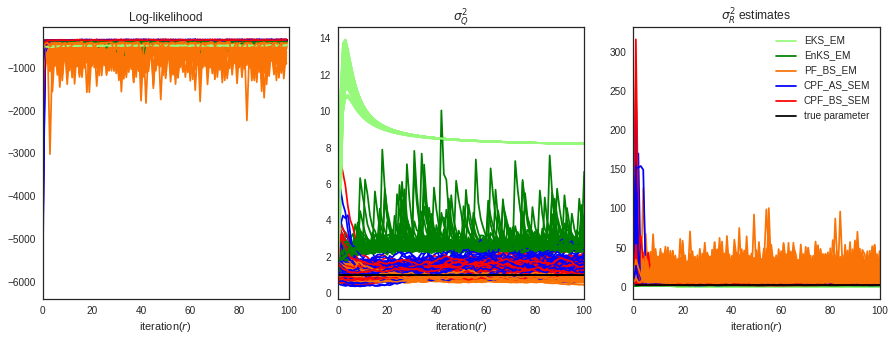

In [5]:
### COMPUTE ESTIMATES WITH CPF-BS-SEM (our approach), CPF-AS-SEM, PF-BS-EM, EnKS-EM, EKS-EM
sns.set_style("white")
plt.rcParams['figure.figsize'] = (15, 5)
plt.figure()
for i in range(rep):
    # uniformly sample the initial covariances
    Q_init = np.random.uniform(aintQ,bintQ)*np.eye(dx)
    R_init = np.random.uniform(aintR,bintR)*np.eye(dy)
    
    ## SEM ALGORITHM using CONDITIONAL PARTICLE FILTERING-BACKWARD SIMULATION SMOOTHER(CPF_BS_SEM)
    # parameters
    pars = { 'conditioning_trajectory'                  : X_conditioning,
               'initial_background_state'                 : xb,
               'initial_background_covariance'            : B,
               'initial_model_noise_covariance'           : Q_init,
               'initial_observation_noise_covariance'     : R_init,
               'model_dynamics'                           : m,
               'observation_matrix'                       : H,
               'observations'                             : Y_learning,
               'nb_filtering_particles'                   : Nf,
               'nb_smoothing_particles'                   : Ns,
               'nb_EM_iterations'                         : N_iter,
               'step_function_SAEM'                       : gam1, # set gam1 for SEM, gam2 for SAEM
               'true_state'                               : X_learning,
               'temporal_window_size'                     : T,
               'state_size'                               : dx,
               'observation_size'                         : dy,
               'is_model_noise_covariance_estimated'      : True,
               'is_observation_noise_covariance_estimated': True,
               'is_background_estimated'                  : False,
               'model_noise_covariance_structure'         : 'const', # chosen variance forms: const, diag, full
               'model_noise_covariance_matrix_template'   : baseQ,
               'observation_noise_covariance_structure'         : 'const', # chosen variance forms: const, diag, full
               'observation_noise_covariance_matrix_template'   : baseR}

    
    res_CPF_BS_SEM = CPF_BS_SEM(pars, prng)

    ## SEM ALGORITHM using CONDITIONAL PARTICLE FILTERING-ANCESTOR SAMPLING SMOOTHER (CPF_AS_SEM) 
    # parameters
    pars = { 'conditioning_trajectory'                  : X_conditioning,
               'initial_background_state'                 : xb,
               'initial_background_covariance'            : B,
               'initial_model_noise_covariance'           : Q_init,
               'initial_observation_noise_covariance'     : R_init,
               'model_dynamics'                           : m,
               'observation_matrix'                       : H,
               'observations'                             : Y_learning,
               'nb_filtering_particles'                   : Nf,
               'nb_smoothing_particles'                   : Ns,
               'nb_EM_iterations'                         : N_iter,
               'step_function_SAEM'                       : gam1,  # set gam1 for SEM, gam2 for SAEM
               'true_state'                               : X_learning,
               'temporal_window_size'                     : T,
               'state_size'                               : dx,
               'observation_size'                         : dy,
               'is_model_noise_covariance_estimated'      : True,
               'is_observation_noise_covariance_estimated': True,
               'is_background_estimated'                  : False,
               'model_noise_covariance_structure'         : 'const', # chosen variance forms: const, diag, full
               'model_noise_covariance_matrix_template'   : baseQ,
               'observation_noise_covariance_structure'         : 'const', # chosen variance forms: const, diag, full
               'observation_noise_covariance_matrix_template'   : baseR}
    
    res_CPF_AS_SEM = CPF_AS_SEM(pars, prng)


    ### EM ALGORITHM using PARTICLE FILTERING-BACKWARD SMOOTHER (PF_BS_EM) (regular)
    # parameters
    pars = { 'initial_background_state'                 : xb,
               'initial_background_covariance'            : B,
               'initial_model_noise_covariance'           : Q_init,
               'initial_observation_noise_covariance'     : R_init,
               'model_dynamics'                           : m,
               'observation_matrix'                       : H,
               'observations'                             : Y_learning,
               'nb_filtering_particles'                   : Nf,
               'nb_smoothing_particles'                   : Ns,
               'nb_EM_iterations'                         : N_iter,
               'step_function_SAEM'                       : gam1, # set gam1 for SEM, gam2 for SAEM
               'true_state'                               : X_learning,
               'temporal_window_size'                     : T,
               'state_size'                               : dx,
               'observation_size'                         : dy,
               'is_model_noise_covariance_estimated'      : True,
               'is_observation_noise_covariance_estimated': True,
               'is_background_estimated'                  : False,
               'model_noise_covariance_structure'         : 'const', # chosen variance forms: const, diag, full
               'model_noise_covariance_matrix_template'   : baseQ,
               'observation_noise_covariance_structure'         : 'const', # chosen variance forms: const, diag, full
               'observation_noise_covariance_matrix_template'   : baseR}
    
    res_PF_BS_EM = PF_BS_EM(pars, prng)

    
    ### EM ALGORITHM using ENSEMBLE KALMAN SMOOTHER (EnKS_EM) (regular)
    # parameters
    pars = { 'initial_background_state'                 : xb,
               'initial_background_covariance'            : B,
               'initial_model_noise_covariance'           : Q_init,
               'initial_observation_noise_covariance'     : R_init,
               'model_dynamics'                           : m,
               'observation_matrix'                       : H,
               'observations'                             : Y_learning,
               'nb_ensemble'                              : N,
               'nb_EM_iterations'                         : N_iter,
               'step_function_SAEM'                       : gam1, # set gam1 for SEM, gam2 for SAEM
               'true_state'                               : X_learning,
               'inflation_factor'                         : 1,
               'temporal_window_size'                     : T,
               'state_size'                               : dx,
               'observation_size'                         : dy,
               'is_model_noise_covariance_estimated'      : True,
               'is_observation_noise_covariance_estimated': True,
               'is_background_estimated'                  : False,
               'model_noise_covariance_structure'         : 'const', # chosen variance forms: const, diag, full
               'model_noise_covariance_matrix_template'   : baseQ,
               'observation_noise_covariance_structure'         : 'const', # chosen variance forms: const, diag, full
               'observation_noise_covariance_matrix_template'   : baseR}
 
    res_EnKS_EM = EnKS_EM(pars, prng)
    
    
    ### EM ALGORITHM using EXTENDED KALMAN SMOOTHER (EKS_EM) (regular)
    # parameters
    pars = { 'initial_background_state'                 : xb,
               'initial_background_covariance'            : B,
               'initial_model_noise_covariance'           : Q_init,
               'initial_observation_noise_covariance'     : R_init,
               'model_dynamics'                           : m,
               'model_jacobian'                           : jacF,
               'observation_operator'                     : h,
               'observation_jacobian'                     : jacH,
               'observations'                             : Y_learning,
               'nb_EM_iterations'                         : N_iter,
               'step_function_SAEM'                       : gam1, # set gam1 for SEM, gam2 for SAEM
               'true_state'                               : X_learning,
               'state_size'                               : dx,
               'observation_size'                         : dy,
               'temporal_window_size'                     : T,
               'is_model_noise_covariance_estimated'      : True,
               'is_observation_noise_covariance_estimated': True,
               'is_background_estimated'                  : False,
               'model_noise_covariance_structure'         : 'const', # chosen variance forms: const, diag, full
               'model_noise_covariance_matrix_template'   : baseQ,
               'observation_noise_covariance_structure'         : 'const', # chosen variance forms: const, diag, full
               'observation_noise_covariance_matrix_template'   : baseR,
               'inflation_factor'                         : 1 }

    res_EKS_EM = EKS_EM(pars)

    ii =0; ilim =0
    #CPF-BSi
    Q_CPF_BS = res_CPF_BS_SEM['EM_model_noise_covariance'][:,:,ii:]
    R_CPF_BS = res_CPF_BS_SEM['EM_observation_noise_covariance'][:,:,ii:]
    loglik_CPF_BS= res_CPF_BS_SEM['loglikelihood'][ii:]
    Q_rep[2,i,:] = np.trace(Q_CPF_BS)/dx
    R_rep[2,i,:] = np.trace(R_CPF_BS)/dy
    loglik_rep[2,i,:] = loglik_CPF_BS
    Xs_CPF_BS = res_CPF_BS_SEM['smoothed_sample_all']
    
    
    #CPF-AS
    Q_CPF_AS = res_CPF_AS_SEM['EM_model_noise_covariance'][:,:,ii:]
    R_CPF_AS = res_CPF_AS_SEM['EM_observation_noise_covariance'][:,:,ii:]
    loglik_CPF_AS= res_CPF_AS_SEM['loglikelihood'][ii:]
    Q_rep[1,i,:] = np.trace(Q_CPF_AS)/dx
    R_rep[1,i,:] = np.trace(R_CPF_AS)/dy
    loglik_rep[1,i,:] = loglik_CPF_AS
    Xs_CPF_AS = res_CPF_AS_SEM['smoothed_sample_all']
    
    #PF-BSi
    Q_PF_BS = res_PF_BS_EM['EM_model_noise_covariance'][:,:,ii:]
    R_PF_BS = res_PF_BS_EM['EM_observation_noise_covariance'][:,:,ii:]
    loglik_PF_BS= res_PF_BS_EM['loglikelihood'][ii:]
    

    #EnKS
    Q_EnKS =  res_EnKS_EM['EM_model_noise_covariance'][:,:,ii:]
    R_EnKS =  res_EnKS_EM['EM_observation_noise_covariance'][:,:,ii:]
    loglik_EnKS= res_EnKS_EM['loglikelihood'][ii:]
    Q_rep[0,i,:] = np.trace(Q_EnKS)/dx
    R_rep[0,i,:] = np.trace(R_EnKS)/dy
    loglik_rep[0,i,:] = loglik_EnKS
    Xs_EnKS = res_EnKS_EM['smoothed_ensemble_all']
    
    #EKS
    Q_EKS =  res_EKS_EM['EM_model_noise_covariance'][:,:,ii:]
    R_EKS =  res_EKS_EM['EM_observation_noise_covariance'][:,:,ii:]
    loglik_EKS= res_EKS_EM['loglikelihood'][ii:]
    
    
    
    # plot log-likelihood estimates
    plt.subplot(1,3,1)
    line0,=plt.plot(loglik_EKS,'xkcd:light green')
    line1,=plt.plot(loglik_EnKS,'g')
    line2,=plt.plot(loglik_PF_BS,'xkcd:orange')
    line3,=plt.plot(loglik_CPF_AS,'b')
    line4,=plt.plot(loglik_CPF_BS,'r')
    plt.title('Log-likelihood')
    plt.xlabel('iteration($r$)')
    plt.xlim([ilim, N_iter])
    
    # plot of sig2_Q estimates
    plt.subplot(1,3,2)
    line0,=plt.plot(np.trace(Q_EKS)/dx, 'xkcd:light green')
    line1,=plt.plot(np.trace(Q_EnKS)/dx,'g')
    line2,=plt.plot(np.trace(Q_PF_BS)/dx, 'xkcd:orange')
    line3,=plt.plot(np.trace(Q_CPF_AS)/dx,'b')
    line4,=plt.plot(np.trace(Q_CPF_BS)/dx,'r')
    line5,=plt.plot((1,N_iter),(np.trace(Q_true)/dx,np.trace(Q_true)/dx),'k')
    plt.xlabel('iteration($r$)')
    plt.title('$\sigma_Q^2$')
    plt.xlim([ilim, N_iter])
    
    # plot sig2_R estimates
    plt.subplot(1,3,3)
    line0,=plt.plot(np.trace(R_EKS)/dy,'xkcd:light green')
    line1,=plt.plot(np.trace(R_EnKS)/dy,'g')
    line2,=plt.plot(np.trace(R_PF_BS)/dy,'xkcd:orange')
    line3,=plt.plot(np.trace(R_CPF_AS)/dy,'-b')
    line4,=plt.plot(np.trace(R_CPF_BS)/dy,'-r')
    line6,=plt.plot((1,N_iter),(np.trace(R_true)/dy,np.trace(R_true)/dy),'k')
    plt.xlabel('iteration($r$)')
    plt.title('$\sigma_R^2$ estimates')
    plt.xlim([ilim, N_iter])
    plt.legend([line0, line1, line2, line3, line4, line5], ['EKS_EM','EnKS_EM', 'PF_BS_EM','CPF_AS_SEM', 'CPF_BS_SEM', 'true parameter'])

   
plt.show()

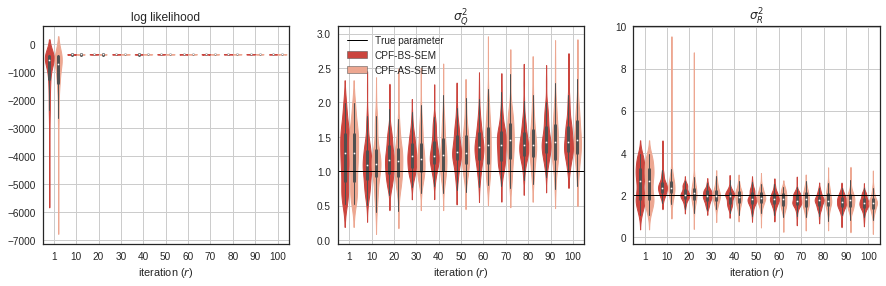

In [6]:
### VIOLIN PLOT of ESTIMATION PERFORMANCES between CPF-BS-SEM and CPF-AS-SEM

ind_box = np.arange(0,N_iter+1,10)
ind_box[1:] = ind_box[1:]-1

data_CAS_Q = Q_rep[1,:,ind_box].T
data_CAS_R = R_rep[1,:,ind_box].T
data_CAS_llh = loglik_rep[1,:,ind_box].T

data_CPS_Q = Q_rep[2,:,ind_box].T 
data_CPS_R = R_rep[2,:,ind_box].T
data_CPS_llh = loglik_rep[2,:,ind_box].T

my_color = "Reds_r" #{"CPF-BS-SEM":"xkcd:light red", "CPF-AS-SEM":"xkcd:light blue"}
my_labels = ["CPF-BS-SEM", "CPF-AS-SEM", "EnKS-EM"]
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style("white")
plt.rcParams['figure.figsize'] = (15, 4)
ind_box = np.arange(0,N_iter+1,10)
ind_box[0] =1
iterations = (np.repeat(ind_box.T,(rep))).reshape(len(ind_box)*rep)
iterations = np.concatenate((iterations,iterations))

est = np.concatenate((data_CPS_llh.T.reshape(len(ind_box)*rep), data_CAS_llh.T.reshape(len(ind_box)*rep)))
methods = np.concatenate((np.repeat("CPF-BS-SEM",len(ind_box)*rep), np.repeat("CPF-AS-SEM",len(ind_box)*rep)))
df = {'iterations':iterations,'est':est,'methods': methods}
DAT = pd.DataFrame(data=df)
plt.figure()
plt.subplot(131)
line2 = sns.violinplot(x ='iterations',y= 'est', hue= 'methods', data= DAT, bw=0.3,palette= my_color, linewidth=1).set_ylabel('')
plt.legend('',frameon=False, loc= 4)
#plt.ylim([-8000,50])
plt.xlabel('iteration ($r$)')
plt.title('log likelihood')
plt.grid()
#plt.xlim([-.5,5.5])

est = np.concatenate((data_CPS_Q.T.reshape(len(ind_box)*rep), data_CAS_Q.T.reshape(len(ind_box)*rep)))
methods = np.concatenate((np.repeat("CPF-BS-SEM",len(ind_box)*rep), np.repeat("CPF-AS-SEM",len(ind_box)*rep)))
df = {'iterations':iterations,'est':est,'methods': methods}
DAT = pd.DataFrame(data=df)
plt.subplot(132)
line2 = sns.violinplot(x ='iterations',y= 'est', hue= 'methods', data= DAT, palette= my_color, linewidth=1).set_ylabel('')
line1 = plt.plot((-0.5,10.5*N_iter/100),(sig2_Q,sig2_Q),'-k',linewidth=1, label = 'True parameter' )
#line0 = plt.plot((-0.5,10.5),(np.squeeze(Q_EKS[:,:,-1]),np.squeeze(Q_EKS[:,:,-1])),'--k',linewidth=1,label = 'True MLE')
plt.legend(frameon=False, loc= 'best')
plt.xlabel('iteration ($r$)')
plt.title(r'$\sigma_Q^2$')
plt.grid()
#plt.xlim([-.25,5.5])
#plt.ylim([-0.25,2.5])

est = np.concatenate(((data_CPS_R.T).reshape(len(ind_box)*rep), (data_CAS_R.T).reshape(len(ind_box)*rep)))
methods = np.concatenate((np.repeat("CPF-BS-SEM",len(ind_box)*rep), np.repeat("CPF-AS-SEM",len(ind_box)*rep)))
df = {'iterations':iterations,'est':est,'methods': methods}
DAT = pd.DataFrame(data=df)
plt.subplot(133)
line2 = sns.violinplot(x ='iterations',y= 'est', hue= 'methods', data= DAT, palette= my_color, linewidth=1).set_ylabel('')
line1 = plt.plot((-0.5,10.5*N_iter/100),(sig2_R,sig2_R),'-k',linewidth=1, label = 'True parameter' )
#line0 = plt.plot((-0.5,10.5),(np.squeeze(R_EKS[:,:,-1]),np.squeeze(R_EKS[:,:,-1])),'--k',linewidth=1,label = 'True MLE')
plt.legend('',frameon=False, loc= 'best')
plt.xlabel('iteration ($r$)')
plt.title(r'$\sigma_R^2$')
plt.grid()
#plt.xlim([-.25,5.5])
#plt.ylim([0,10])
plt.show()

RMSE of $x_1$: 0.8378006823670259
coverage probability of $x_1$: 85.0%
RMSE of $x_2$: 1.0928049548084673
coverage probability of $x_2$: 80.0%
RMSE of $x_3$: 1.1134727199847623
coverage probability of $x_3$: 82.0%


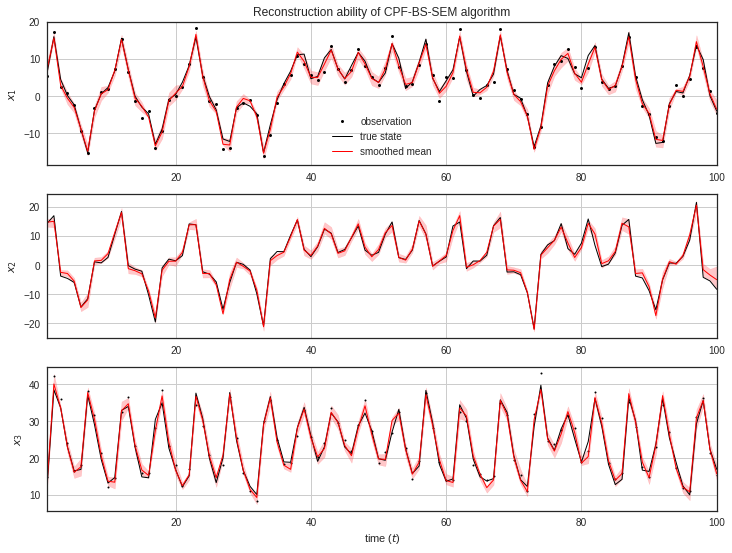

In [7]:
### RECONSTRUCTION LATENT STATES with CPF-BS-SEM
## Plot of realizations generated from last $10$ iterations of the algorithm

from algos.utils import RMSE, CV95
time_learning = np.arange(T+1)
sns.set_style("white")
plt.rcParams['figure.figsize'] = (12, 9)
plt.figure()
num=10
var =0
Xs = np.squeeze(Xs_CPF_BS[var,:,:,N_iter+1-num:]).transpose((2,0,1))
Xs = Xs.reshape(Ns*num,T+1)
Xs_mean = Xs.mean(axis=0)
cov_prob, CIlowXs, CIupXs = CV95(Xs[:,1:],X_learning[var,1:])
RMSE_CPF_BS= RMSE(X_learning[var,1:] - Xs[:,1:].mean(0))
#cov_prob, CIlowXs, CIupXs = CV95(Xs[:,1:],X_learning[var,1:])
print('RMSE of $x_{}$: {}'.format(var+1,RMSE_CPF_BS))
print('coverage probability of $x_{}$: {}%'.format(var+1,cov_prob))

plt.subplot(311)
line = plt.fill_between(time_learning[1:], CIlowXs,CIupXs, color="xkcd:light red", alpha=0.3)#,sig2_Qha =0.3 )
line0 = plt.plot(time_learning[1:],Y_learning[var,:], '.k', markersize = 6, label ='observation')
line1 = plt.plot(time_learning[1:],X_learning[var,1:], '-k', linewidth =1, label = 'true state')
line2 = plt.plot(time_learning[1:],Xs_mean[1:],'red',linewidth =1, label ='smoothed mean')
plt.legend(loc = 'lower center', ncol =1)
plt.title('Reconstruction ability of CPF-BS-SEM algorithm')
plt.xlim([1,T])
plt.ylabel('$x_1$')
plt.grid()

plt.subplot(312)
var = 1
Xs = np.squeeze(Xs_CPF_BS[var,:,:,N_iter+1-num:]).transpose((2,0,1))
Xs = Xs.reshape(Ns*num,T+1)
Xs_mean = Xs.mean(axis=0)
cov_prob, CIlowXs, CIupXs = CV95(Xs[:,1:],X_learning[var,1:])
RMSE_CPF_BS= RMSE(X_learning[var,1:] - Xs[:,1:].mean(0))
print('RMSE of $x_{}$: {}'.format(var+1,RMSE_CPF_BS))
print('coverage probability of $x_{}$: {}%'.format(var+1,cov_prob))

line = plt.fill_between(time_learning[1:], CIlowXs,CIupXs, color="xkcd:light red", alpha=0.3)#,sig2_Qha =0.3 )
#line0 = plt.plot(time[1:],Y_learning[var,:], '.k', markersize = 6, label ='observation')
line1 = plt.plot(time_learning[1:],X_learning[var,1:], '-k', linewidth =1, label = 'true state')
line2 = plt.plot(time_learning[1:],Xs_mean[1:],'red',linewidth =1, label ='smoothed mean')
plt.xlim([1,T])
plt.ylabel('$x_2$')
plt.grid()

plt.subplot(313)
var = 2
Xs = np.squeeze(Xs_CPF_BS[var,:,:,N_iter+1-num:]).transpose((2,0,1))
Xs = Xs.reshape(Ns*num,T+1)
Xs_mean = Xs.mean(axis=0)
cov_prob, CIlowXs, CIupXs = CV95(Xs[:,1:],X_learning[var,1:])
RMSE_CPF_BS= RMSE(X_learning[var,1:] - Xs[:,1:].mean(0))
print('RMSE of $x_{}$: {}'.format(var+1,RMSE_CPF_BS))
print('coverage probability of $x_{}$: {}%'.format(var+1,cov_prob))

line = plt.fill_between(time_learning[1:], CIlowXs,CIupXs, color="xkcd:light red", alpha=0.3)#,sig2_Qha =0.3 )
line0 = plt.plot(time_learning[1:],Y_learning[var-1,:], '.k', markersize = 4, label ='observation')
line1 = plt.plot(time_learning[1:],X_learning[var,1:], '-k', linewidth =1, label = 'true state')
line2 = plt.plot(time_learning[1:],Xs_mean[1:],'red',linewidth =1, label ='smoothed mean')
plt.xlabel('time ($t$)')
plt.ylabel('$x_3$')
plt.xlim([1,T])
plt.grid()
plt.show()

RMSE_CPF_BS of $x_2$= 1.337580656334003
cov_prob CPF_BS of $x_2$ =89.0%
RMSE_CPF_AS of $x_2$ = 1.6020890287354888
cov_prob CPF_AS of $x_2$ = 77.9%


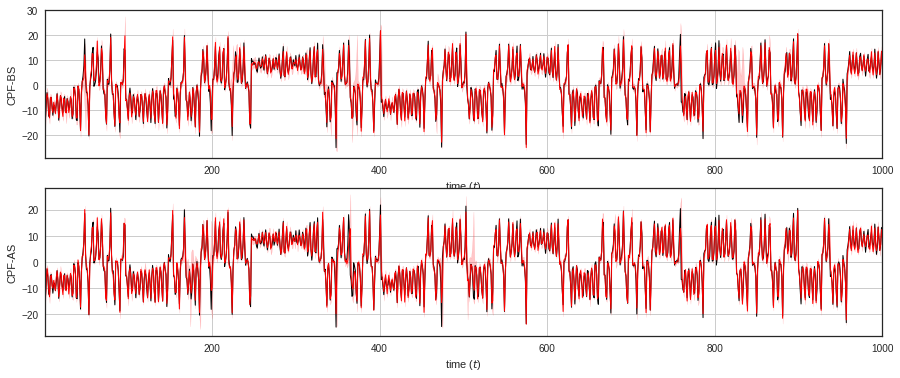

In [8]:
### COMPARE RECONSTRUCTION QUALITY (RMSE and COVERAGE PROBABILITY) between CPF-BS SMOOTHER and CPF-AS SMOOTHER with THEIR ESTIMATED PARAMETERS ON A TESTING DATA

from algos.CPF_BS_SEM import CPF_BS
from algos.CPF_AS_SEM import CPF_AS
# random number generator
#prng = RandomState(1)

#testing data
T_testing =1000 # 10 Lorenz-63 times
time = range(T_testing)*np.array([dt])
X_testing = X[:,T0-T_testing:]
Y_testing =  Y[:,T0-T_testing:]
B = np.eye(dx) *sig2_Q
xb= X_testing[:,0]

Nf=20; Ns=20; Niter=10
X_conditioning = np.zeros([dx,T_testing])

Q_CPF_AS = np.mean(Q_rep[1,:,-1])*baseQ
R_CPF_AS = np.mean(R_rep[1,:,-1])*baseR

Q_CPF_BS = np.mean(Q_rep[2,:,-1])*baseQ
R_CPF_BS = np.mean(R_rep[2,:,-1])*baseR

# CPF-BS
pars =   { 'conditioning_trajectory'                  : X_conditioning,
           'background_state'                         : xb,
           'background_covariance'                    : B,
           'model_noise_covariance'                   : Q_CPF_BS,
           'observation_noise_covariance'             : R_CPF_BS,
           'model_dynamics'                           : m,
           'observation_matrix'                       : H,
           'observations'                             : Y_testing,
           'nb_filtering_particles'                   : Nf,
           'nb_smoothing_particles'                   : Ns,
           'nb_iterations'                            : Niter,
           'true_state'                               : X_testing,
           'inflation_factor'                         : 1,
           'temporal_window_size'                     : T_testing,
           'state_size'                               : dx,
           'observation_size'                         : dy}

res_CPF_BS = CPF_BS(pars, prng)   
Xs_CPF_BS = res_CPF_BS['smoothed_sample_all']

#CPF-AS
pars = { 'conditioning_trajectory'                  : X_conditioning,
           'background_state'                         : xb,
           'background_covariance'                    : B,
           'model_noise_covariance'                   : Q_CPF_AS,
           'observation_noise_covariance'             : R_CPF_AS,
           'model_dynamics'                           : m,
           'observation_matrix'                       : H,
           'observations'                             : Y_testing,
           'nb_filtering_particles'                   : Nf,
           'nb_smoothing_particles'                   : Ns,
           'nb_iterations'                            : Niter,
           'true_state'                               : X_testing,
           'inflation_factor'                         : 1,
           'temporal_window_size'                     : T_testing,
           'state_size'                               : dx,
           'observation_size'                         : dy}
    #%pdb
    # function
res_CPF_AS = CPF_AS(pars, prng)  
Xs_CPF_AS = res_CPF_AS['smoothed_sample_all']
#plot
time = np.arange(T_testing+1)
var = 1; num =10; tlim= [1,T_testing]
num1=Niter;num2= num +Niter+1-num1
XsBS = np.squeeze(Xs_CPF_BS[var,:,:,Niter+1-num1:num2]).transpose((2,0,1))
XsAS = np.squeeze(Xs_CPF_AS[var,:,:,Niter+1-num1:num2]).transpose((2,0,1))
XsBS = XsBS.reshape(Ns*num,T_testing+1)
XsAS = XsAS.reshape(Ns*num,T_testing+1)

XsBS_mean = XsBS.mean(axis=0); XsAS_mean = XsAS.mean(axis=0); 
cov_prob, CIlowBS, CIupBS = CV95(XsBS[:,1:],X_testing[var,1:])
RMSE_CPF_BS= RMSE(X_testing[var,1:] - XsBS[:,1:].mean(0))
print('RMSE_CPF_BS of $x_{}$= {}'.format(var+1,RMSE_CPF_BS))
print('cov_prob CPF_BS of $x_{}$ ={}%'.format(var+1,cov_prob))

cov_prob, CIlowAS, CIupAS = CV95(XsAS[:,1:],X_testing[var,1:])
RMSE_CPF_AS= RMSE(X_testing[var,1:] - XsAS[:,1:].mean(0))
print('RMSE_CPF_AS of $x_{}$ = {}'.format(var+1,RMSE_CPF_AS))
print('cov_prob CPF_AS of $x_{}$ = {}%'.format(var+1,cov_prob))

plt.rcParams['figure.figsize'] = (15, 6)
plt.figure()
plt.subplot(211)
line = plt.fill_between(time[1:], CIlowBS,CIupBS, color="xkcd:light red", alpha=0.3)#,sig2_Qha =0.3 )
#line0 = plt.plot(time[1:],Y_learning[var-1,:], '.k', markersize = 4, label ='observation')
line1 = plt.plot(time[1:],X_testing[var,1:], '-k', linewidth =1, label = 'true state')
line2 = plt.plot(time[1:],XsBS_mean[1:],'red',linewidth =1, label ='smoothed mean')
plt.xlabel('time ($t$)')
plt.ylabel('CPF-BS')
plt.xlim([1,T_testing])
plt.grid()

plt.subplot(212)
line = plt.fill_between(time[1:], CIlowAS,CIupAS, color="xkcd:light red", alpha=0.3)#,sig2_Qha =0.3 )
#line0 = plt.plot(time[1:],Y_learning[var-1,:], '.k', markersize = 4, label ='observation')
line1 = plt.plot(time[1:],X_testing[var,1:], '-k', linewidth =1, label = 'true state')
line2 = plt.plot(time[1:],XsAS_mean[1:],'red',linewidth =1, label ='smoothed mean')
plt.xlabel('time ($t$)')
plt.ylabel('CPF-AS')
plt.xlim([1,T_testing])
plt.grid()
plt.show()